In [1]:
import music21 as m21
import pretty_midi as pm
from pathlib import Path
import pickle
import pandas as pd
import json
from collections import Counter

import numpy as np
from matplotlib import pyplot as plt

In [2]:
#helper functions and data structures

from pitches import PITCHES
from pitches import INTERVALS

accepted_pitches = [ii for i in PITCHES.values() for ii in i]
print([e for e in enumerate(accepted_pitches)])

double_acc_pitches = [ii for i in PITCHES.values() for ii in i if ii.endswith("##") or  ii.endswith("--") ]
print(double_acc_pitches)

def score2midi_numbers(score):
    return [p.midi%12 for n in score.flat.notes for p in n.pitches]

def score2pitches(score):
    return [p.name for n in score.flat.notes for p in n.pitches]

def score2pitches_meredith(score):
    # Return the David Meredith style of pitches (http://www.titanmusic.com/data.php)
    return [p.nameWithOctave.replace("s","#").replace("f","-")
            if ("#" in p.nameWithOctave) or ("-" in p.nameWithOctave)
            else p.nameWithOctave.replace("s","#").replace("f","-")[:-1] + "n" + p.nameWithOctave.replace("s","#").replace("f","-")[-1]
            for n in score.flat.notes for p in n.pitches]

def score2onsets(score):
    return [n.offset for n in score.flat.notes for p in n.pitches]

def score2durations(score):
    return [n.duration.quarterLength for n in score.flat.notes for p in n.pitches]

def score2ks(score):
    """Return one ks for each pitch for each note"""
    temp_ks = None
    out = []
    for event in score.flat:
        if isinstance(event, m21.key.KeySignature):
#             print("Found a ks")
            temp_ks = event.sharps
        elif isinstance(event,m21.note.NotRest):
            for pitch in event.pitches:
#                 print("FOund a note")
                out.append(temp_ks)
    return out

accepted_intervals = [ii for i in INTERVALS.values() for ii in i]
print([e for e in enumerate(accepted_intervals)])

def transp_score(score):
    """ For each input return len(accepted_intervals) transposed scores"""
    return [score.transpose(interval) for interval in accepted_intervals]

def transp_note_list(note_list):
    """ For each input return len(accepted_intervals) transposed list of notes"""
    return [[n.transpose(interval) for n in note_list] for interval in accepted_intervals]

def acc_simple_enough(score,accepted_ratio = 0.2 ):
    pitches = score2pitches(score)
    double_acc = sum(el in double_acc_pitches for el in pitches)
    if double_acc/len(pitches) < accepted_ratio:
        return True
    else:
        return False

[(0, 'C'), (1, 'B#'), (2, 'D--'), (3, 'C#'), (4, 'B##'), (5, 'D-'), (6, 'D'), (7, 'C##'), (8, 'E--'), (9, 'D#'), (10, 'E-'), (11, 'F--'), (12, 'E'), (13, 'D##'), (14, 'F-'), (15, 'F'), (16, 'E#'), (17, 'G--'), (18, 'F#'), (19, 'E##'), (20, 'G-'), (21, 'G'), (22, 'F##'), (23, 'A--'), (24, 'G#'), (25, 'A-'), (26, 'A'), (27, 'G##'), (28, 'B--'), (29, 'A#'), (30, 'B-'), (31, 'C--'), (32, 'B'), (33, 'A##'), (34, 'C-')]
['D--', 'B##', 'C##', 'E--', 'F--', 'D##', 'G--', 'E##', 'F##', 'A--', 'G##', 'B--', 'C--', 'A##']
[(0, 'P1'), (1, 'd2'), (2, 'A7'), (3, 'm2'), (4, 'A1'), (5, 'M2'), (6, 'd3'), (7, 'AA1'), (8, 'm3'), (9, 'A2'), (10, 'M3'), (11, 'd4'), (12, 'AA2'), (13, 'P4'), (14, 'A3'), (15, 'd5'), (16, 'A4'), (17, 'P5'), (18, 'd6'), (19, 'AA4'), (20, 'm6'), (21, 'A5'), (22, 'M6'), (23, 'd7'), (24, 'AA5'), (25, 'm7'), (26, 'A6'), (27, 'M7'), (28, 'd1'), (29, 'AA6')]


# OPND dataset

In [3]:
opnd_basepath = Path("datasets/opnd/")

In [82]:
opnd_dataset_dict = []

def parenthetic_contents(string):
    """Parse nested parentheses."""
    stack = []
    for i, c in enumerate(string):
        if c == '(':
            stack.append(i)
        elif c == ')' and stack:
            if len(stack) ==2: # only consider elements at depth 2
                start = stack.pop()
                yield string[start + 1: i]


print("Total scores to process:", len(list(opnd_basepath.iterdir())))
for ifile,file in enumerate(opnd_basepath.iterdir()):
    with open(file,'r') as f:
        file_content = f.read()
    print("Processing file", ifile, str(file))
    strings_list = list(parenthetic_contents(file_content))
    quadruples_list = [s.split(" ") for s in strings_list ]
    # sort by start input and pitch
    quadruples_list = sorted(quadruples_list, key=lambda tup: int(tup[0]))
    # put the information in a list of dicts
    pitches = [q[1].strip('"').replace("n","").replace("s","#").replace("f","-") for q in quadruples_list]
    # transform pitches in music21 notes
    m21_notes = [m21.note.Note(p) for p in pitches]
    # transpose to all intervals
    for interval in accepted_intervals:
        transp_m21_notes = [n.transpose(interval) for n in m21_notes ]
        transp_pitches = [n.pitch.name for n in transp_m21_notes]
        if all(p in accepted_pitches for p in transp_pitches): #consider only ok pitches
            opnd_dataset_dict.append({
                'onset': [int(q[0]) for q in quadruples_list],
                'duration' : [int(q[2]) for q in quadruples_list],
                'pitches': transp_pitches,
                'midi_number' : [n.pitch.midi%12 for n in transp_m21_notes],
                'transposed_of' : interval,
                'key_signature' : None,
                'original_ks' : None,
                'original_path' : str(file)
            })

Total scores to process: 216
Processing file 0 datasets\opnd\bachbgcant000905m.opnd-m
Processing file 1 datasets\opnd\bachbgcant002003m.opnd-m
Processing file 2 datasets\opnd\bachbgcant004206m.opnd-m
Processing file 3 datasets\opnd\bachbgcant004407m.opnd-m
Processing file 4 datasets\opnd\bachbgcant004902m.opnd-m
Processing file 5 datasets\opnd\bachbgcant012201m.opnd-m
Processing file 6 datasets\opnd\bachbgcant013606m.opnd-m
Processing file 7 datasets\opnd\bachbgcant015303m.opnd-m
Processing file 8 datasets\opnd\bachbgcant015308m.opnd-m
Processing file 9 datasets\opnd\bachbgcant016503m.opnd-m
Processing file 10 datasets\opnd\bachbgcant017104m.opnd-m
Processing file 11 datasets\opnd\bachbgchoral027601m.opnd-m
Processing file 12 datasets\opnd\bachbgchoral030201m.opnd-m
Processing file 13 datasets\opnd\bachbgchoral032701m.opnd-m
Processing file 14 datasets\opnd\bachbgchoral035201m.opnd-m
Processing file 15 datasets\opnd\bachbgchoral037701m.opnd-m
Processing file 16 datasets\opnd\bachbgchor

Processing file 131 datasets\opnd\haydndoverquartop55n101m.opnd-m
Processing file 132 datasets\opnd\haydndoverquartop55n302m.opnd-m
Processing file 133 datasets\opnd\haydndoverquartop64n102m.opnd-m
Processing file 134 datasets\opnd\haydndoverquartop64n202m.opnd-m
Processing file 135 datasets\opnd\haydndoversyms-09902m.opnd-m
Processing file 136 datasets\opnd\haydndoversyms-10004m.opnd-m
Processing file 137 datasets\opnd\haydndoversyms-10202m.opnd-m
Processing file 138 datasets\opnd\haydndoversyms-10302m.opnd-m
Processing file 139 datasets\opnd\mozartbhconck45903m.opnd-m
Processing file 140 datasets\opnd\mozartbhconck62202m.opnd-m
Processing file 141 datasets\opnd\mozartbhduosk42302m.opnd-m
Processing file 142 datasets\opnd\mozartbhduosk42402m.opnd-m
Processing file 143 datasets\opnd\mozartbhqrtetsk08003m.opnd-m
Processing file 144 datasets\opnd\mozartbhqrtetsk15602m.opnd-m
Processing file 145 datasets\opnd\mozartbhqrtetsk15802m.opnd-m
Processing file 146 datasets\opnd\mozartbhqrtetsk16

In [78]:
for d in opnd_dataset_dict:
    print(d["midi_number"][:6],d["pitches"][:6],d["transposed_of"],d["original_path"])

[9, 4, 6, 4, 2, 1] ['A', 'E', 'F#', 'E', 'D', 'C#'] P1 datasets\opnd\bachbgcant000905m.opnd-m
[9, 4, 6, 4, 2, 1] ['B--', 'F-', 'G-', 'F-', 'E--', 'D-'] d2 datasets\opnd\bachbgcant000905m.opnd-m
[10, 5, 7, 5, 3, 2] ['B-', 'F', 'G', 'F', 'E-', 'D'] m2 datasets\opnd\bachbgcant000905m.opnd-m
[10, 5, 7, 5, 3, 2] ['A#', 'E#', 'F##', 'E#', 'D#', 'C##'] A1 datasets\opnd\bachbgcant000905m.opnd-m
[11, 6, 8, 6, 4, 3] ['B', 'F#', 'G#', 'F#', 'E', 'D#'] M2 datasets\opnd\bachbgcant000905m.opnd-m
[11, 6, 8, 6, 4, 3] ['C-', 'G-', 'A-', 'G-', 'F-', 'E-'] d3 datasets\opnd\bachbgcant000905m.opnd-m
[0, 7, 9, 7, 5, 4] ['C', 'G', 'A', 'G', 'F', 'E'] m3 datasets\opnd\bachbgcant000905m.opnd-m
[1, 8, 10, 8, 6, 5] ['C#', 'G#', 'A#', 'G#', 'F#', 'E#'] M3 datasets\opnd\bachbgcant000905m.opnd-m
[1, 8, 10, 8, 6, 5] ['D-', 'A-', 'B-', 'A-', 'G-', 'F'] d4 datasets\opnd\bachbgcant000905m.opnd-m
[2, 9, 11, 9, 7, 6] ['D', 'A', 'B', 'A', 'G', 'F#'] P4 datasets\opnd\bachbgcant000905m.opnd-m
[3, 10, 0, 10, 8, 7] ['E-', 'B-

In [85]:
# save dataset
with open('musedata.pkl', 'wb') as fid:
     pickle.dump(opnd_dataset_dict, fid)

# OPND noisy dataset

In [3]:
opnd_basepath = Path("../opnd-m-noisy/")

In [5]:
opnd_dataset_dict = []

def parenthetic_contents(string):
    """Parse nested parentheses."""
    stack = []
    for i, c in enumerate(string):
        if c == '(':
            stack.append(i)
        elif c == ')' and stack:
            if len(stack) ==2: # only consider elements at depth 2
                start = stack.pop()
                yield string[start + 1: i]


print("Total scores to process:", len(list(opnd_basepath.iterdir())))
for ifile,file in enumerate(opnd_basepath.iterdir()):
    with open(file,'r') as f:
        file_content = f.read()
    print("Processing file", ifile, str(file))
    strings_list = list(parenthetic_contents(file_content))
    quadruples_list = [s.split(" ") for s in strings_list ]
    # sort by start input and pitch
    quadruples_list = sorted(quadruples_list, key=lambda tup: int(tup[0]))
    # put the information in a list of dicts
    pitches = [q[1].strip('"').replace("n","").replace("s","#").replace("f","-") for q in quadruples_list]
    # transform pitches in music21 notes
    m21_notes = [m21.note.Note(p) for p in pitches]
    # transpose to all intervals
    for interval in ["P1"]: #not interested in data augmentation, just take the original piece
        transp_m21_notes = [n.transpose(interval) for n in m21_notes ]
        transp_pitches = [n.pitch.name for n in transp_m21_notes]
        if all(p in accepted_pitches for p in transp_pitches): #consider only ok pitches
            opnd_dataset_dict.append({
                'onset': [int(q[0]) for q in quadruples_list],
                'duration' : [int(q[2]) for q in quadruples_list],
                'pitches': transp_pitches,
                'midi_number' : [n.pitch.midi%12 for n in transp_m21_notes],
                'transposed_of' : interval,
                'key_signature' : None,
                'original_ks' : None,
                'original_path' : str(file)
            })

Total scores to process: 216
Processing file 0 ..\opnd-m-noisy\bachbgcant000905m.opnd-m
Processing file 1 ..\opnd-m-noisy\bachbgcant002003m.opnd-m
Processing file 2 ..\opnd-m-noisy\bachbgcant004206m.opnd-m
Processing file 3 ..\opnd-m-noisy\bachbgcant004407m.opnd-m
Processing file 4 ..\opnd-m-noisy\bachbgcant004902m.opnd-m
Processing file 5 ..\opnd-m-noisy\bachbgcant012201m.opnd-m
Processing file 6 ..\opnd-m-noisy\bachbgcant013606m.opnd-m
Processing file 7 ..\opnd-m-noisy\bachbgcant015303m.opnd-m
Processing file 8 ..\opnd-m-noisy\bachbgcant015308m.opnd-m
Processing file 9 ..\opnd-m-noisy\bachbgcant016503m.opnd-m
Processing file 10 ..\opnd-m-noisy\bachbgcant017104m.opnd-m
Processing file 11 ..\opnd-m-noisy\bachbgchoral027601m.opnd-m
Processing file 12 ..\opnd-m-noisy\bachbgchoral030201m.opnd-m
Processing file 13 ..\opnd-m-noisy\bachbgchoral032701m.opnd-m
Processing file 14 ..\opnd-m-noisy\bachbgchoral035201m.opnd-m
Processing file 15 ..\opnd-m-noisy\bachbgchoral037701m.opnd-m
Processing 

Processing file 127 ..\opnd-m-noisy\handelhicksott38m.opnd-m
Processing file 128 ..\opnd-m-noisy\handelhicksott69m.opnd-m
Processing file 129 ..\opnd-m-noisy\haydnbhsyms-00102m.opnd-m
Processing file 130 ..\opnd-m-noisy\haydndoverquartop54n203m.opnd-m
Processing file 131 ..\opnd-m-noisy\haydndoverquartop55n101m.opnd-m
Processing file 132 ..\opnd-m-noisy\haydndoverquartop55n302m.opnd-m
Processing file 133 ..\opnd-m-noisy\haydndoverquartop64n102m.opnd-m
Processing file 134 ..\opnd-m-noisy\haydndoverquartop64n202m.opnd-m
Processing file 135 ..\opnd-m-noisy\haydndoversyms-09902m.opnd-m
Processing file 136 ..\opnd-m-noisy\haydndoversyms-10004m.opnd-m
Processing file 137 ..\opnd-m-noisy\haydndoversyms-10202m.opnd-m
Processing file 138 ..\opnd-m-noisy\haydndoversyms-10302m.opnd-m
Processing file 139 ..\opnd-m-noisy\mozartbhconck45903m.opnd-m
Processing file 140 ..\opnd-m-noisy\mozartbhconck62202m.opnd-m
Processing file 141 ..\opnd-m-noisy\mozartbhduosk42302m.opnd-m
Processing file 142 ..\opnd

In [6]:
# save dataset
with open('musedata_noisy.pkl', 'wb') as fid:
     pickle.dump(opnd_dataset_dict, fid)

# ASAP Dataset

In [3]:
asap_basepath = Path("../asap-dataset/")

In [4]:
# load the dataset info
df = pd.read_csv(Path(asap_basepath,'metadata.csv'))
df = df.drop_duplicates(subset=["title","composer"])

with open(Path(asap_basepath,'asap_annotations.json')) as json_file:
      json_data = json.load(json_file)

# accidentals_list = [list(json_data[m]["midi_score_key_signatures"].values())[0][1] for m  in df["midi_performance"]]
xml_score_paths = list(df["xml_score"])

print("N of pieces: ", len(xml_score_paths))

N of pieces:  222


In [12]:
asap_dataset_dict = []

for i,path in enumerate(xml_score_paths):
    print("About to process",path)
    score = m21.converter.parse(Path(asap_basepath,path))
    # generate the transpositions for the piece
    all_scores = transp_score(score)
    #delete the pieces with non accepted pitches (e.g. triple sharps)
    intervals= []
    scores = []
    for s,interval in zip(all_scores,accepted_intervals):
        if all(pitch in accepted_pitches for pitch in score2pitches(s)):
            scores.append(s)
            intervals.append(interval)
    #append all information to the dictionary 
    asap_dataset_dict.extend([
        {
            'onset':score2onsets(s),
            'duration' : score2durations(s),
            'pitches': score2pitches(s),
            'transposed_of': interval,
            'midi_number' : score2midi_numbers(s),
            'key_signature' : s.parts[0].flat.getElementsByClass(m21.key.KeySignature)[0].sharps,
            'original_ks' : score.parts[0].flat.getElementsByClass(m21.key.KeySignature)[0].sharps,
            'original_path' : str(path),
            'composer' : str(path).split("/")[0]
            } 
        for s,interval in zip(scores,intervals)])

About to process Bach/Fugue/bwv_846/xml_score.musicxml
About to process Bach/Fugue/bwv_848/xml_score.musicxml
About to process Bach/Fugue/bwv_854/xml_score.musicxml
About to process Bach/Fugue/bwv_856/xml_score.musicxml
About to process Bach/Fugue/bwv_857/xml_score.musicxml
About to process Bach/Fugue/bwv_858/xml_score.musicxml
About to process Bach/Fugue/bwv_860/xml_score.musicxml
About to process Bach/Fugue/bwv_862/xml_score.musicxml
About to process Bach/Fugue/bwv_863/xml_score.musicxml
About to process Bach/Fugue/bwv_864/xml_score.musicxml
About to process Bach/Fugue/bwv_865/xml_score.musicxml
About to process Bach/Fugue/bwv_866/xml_score.musicxml
About to process Bach/Fugue/bwv_867/xml_score.musicxml
About to process Bach/Fugue/bwv_868/xml_score.musicxml
About to process Bach/Fugue/bwv_870/xml_score.musicxml
About to process Bach/Fugue/bwv_873/xml_score.musicxml
About to process Bach/Fugue/bwv_874/xml_score.musicxml
About to process Bach/Fugue/bwv_875/xml_score.musicxml
About to p

About to process Chopin/Etudes_op_25/2/xml_score.musicxml
About to process Chopin/Etudes_op_25/4/xml_score.musicxml
About to process Chopin/Etudes_op_25/5/xml_score.musicxml
About to process Chopin/Etudes_op_25/8/xml_score.musicxml
About to process Chopin/Polonaises/53/xml_score.musicxml
About to process Chopin/Scherzos/20/xml_score.musicxml
About to process Chopin/Scherzos/31/xml_score.musicxml
About to process Chopin/Scherzos/39/xml_score.musicxml
About to process Chopin/Sonata_2/1st_no_repeat/xml_score.musicxml
About to process Chopin/Sonata_2/2nd/xml_score.musicxml
About to process Chopin/Sonata_2/3rd/xml_score.musicxml
About to process Chopin/Sonata_2/4th/xml_score.musicxml
About to process Chopin/Sonata_3/2nd/xml_score.musicxml
About to process Chopin/Sonata_3/3rd/xml_score.musicxml
About to process Chopin/Sonata_3/4th/xml_score.musicxml
About to process Debussy/Images_Book_1/1_Reflets_dans_lEau/xml_score.musicxml
About to process Debussy/Pour_le_Piano/1/xml_score.musicxml
About 

In [13]:
# save dataset
with open('asap.pkl', 'wb') as fid:
     pickle.dump(asap_dataset_dict, fid)

### Split augmented asap in multiple smaller datasets for github

In [2]:
#import dataset
with open(Path('../other-datasets','asap.pkl'), 'rb') as fid:
     asap_dataset_dict = pickle.load(fid)

In [3]:
author_dict = Counter()
for e in asap_dataset_dict:
    author_dict[e["composer"]] +=1

print(author_dict)

Counter({'Bach': 1232, 'Beethoven': 1028, 'Chopin': 508, 'Schubert': 220, 'Haydn': 217, 'Liszt': 212, 'Schumann': 161, 'Mozart': 114, 'Rachmaninoff': 83, 'Ravel': 56, 'Debussy': 28, 'Scriabin': 24, 'Glinka': 21, 'Brahms': 17, 'Prokofiev': 14, 'Balakirev': 7})


Split according to style

In [4]:
#split according to style

baroque_composers = ['Bach','Haydn','Mozart']
classical_composers = ['Beethoven']
romantic_composers = ['Schubert','Schumann','Chopin', 'Brahms']
remaining_composers = [e for e in author_dict.keys() if e not in baroque_composers+classical_composers+romantic_composers]

baroque_asap_dataset_dict = [e for e in asap_dataset_dict
                              if e["composer"] in baroque_composers]

classical_asap_dataset_dict = [e for e in asap_dataset_dict
                              if e["composer"] in classical_composers]

romantic_asap_dataset_dict = [e for e in asap_dataset_dict
                              if e["composer"] in romantic_composers]

remaining_asap_dataset_dict = [e for e in asap_dataset_dict
                              if e["composer"] in remaining_composers]

In [5]:
with open(Path('datasets','classical_asap.pkl'), 'wb') as fid:
     pickle.dump(classical_asap_dataset_dict, fid)
        
with open(Path('datasets','baroque_asap.pkl'), 'wb') as fid:
     pickle.dump(baroque_asap_dataset_dict, fid)
        
with open(Path('datasets','romantic_asap.pkl'), 'wb') as fid:
     pickle.dump(romantic_asap_dataset_dict, fid)
        
with open(Path('datasets','remaining_asap.pkl'), 'wb') as fid:
     pickle.dump(remaining_asap_dataset_dict, fid)

### Find pieces on musedata that are also on asap

In [9]:
# load musedata
with open('./datasets/aug_musedata.pkl', 'rb') as fid:
     mdata_dataset_dict = pickle.load( fid)

In [42]:
print(mdata_dataset_dict[0].keys())
original_mdata = [e for e in mdata_dataset_dict if e["transposed_of"]=="P1"]
original_asap = [e for e in asap_dataset_dict if e["transposed_of"]=="P1"]

dict_keys(['onset', 'duration', 'pitches', 'midi_number', 'transposed_of', 'key_signature', 'original_ks', 'original_path'])


In [92]:
import editdistance

# @numba.jit(nopython=False)
# def find_equal_pieces(ds1,ds2):
#     out = []
#     for me in ds1:
#         for ae in ds2:
#             musepiece = me["midi_number"]
#             asappiece = ae["midi_number"]
#             out.append((ae["original_path"],me["original_path"],textdistance.levenshtein.similarity(musepiece,asappiece)))
#     return out

def find_equal_pieces(ds1,ds2):
     return [
        {"asap_path":ae["original_path"],
         "musedata_path": me["original_path"],
         "asap_len": len(ae["midi_number"]),
         "musedata_len": len(me["midi_number"]),
         "edit_distance": editdistance.eval(me["midi_number"],ae["midi_number"])
        }
        for me in ds1 for ae in ds2 
        if abs((len(me["midi_number"])-len(ae["midi_number"]))/len(me["midi_number"])) < 0.1
        and me["original_path"].split("\\")[-1][:3].lower() == ae["original_path"].split("/")[0][:3].lower()
     ]
                
similar_list = find_equal_pieces(original_mdata,original_asap)

In [113]:
print(len(similar_list))
to_check = [e for e in similar_list if e["edit_distance"]<300 ]
print(len(to_check))
to_check

157
1


[{'asap_path': 'Bach/Prelude/bwv_865/xml_score.musicxml',
  'musedata_path': 'datasets\\opnd\\bachbgkeybdwtc-i086501m.opnd-m',
  'asap_len': 648,
  'musedata_len': 608,
  'edit_distance': 298}]

In [112]:
mdata_composers = Counter([me["original_path"].split("\\")[-1][:3].lower() for me in original_mdata ])
print(mdata_composers.keys())
[(r["composer"],r["title"]) for i,r in df.iterrows() if r["composer"][:3].lower() in mdata_composers.keys() ]

dict_keys(['bac', 'bee', 'cor', 'han', 'hay', 'moz', 'tel', 'viv'])


[('Bach', 'Fugue_bwv_846'),
 ('Bach', 'Fugue_bwv_848'),
 ('Bach', 'Fugue_bwv_854'),
 ('Bach', 'Fugue_bwv_856'),
 ('Bach', 'Fugue_bwv_857'),
 ('Bach', 'Fugue_bwv_858'),
 ('Bach', 'Fugue_bwv_860'),
 ('Bach', 'Fugue_bwv_862'),
 ('Bach', 'Fugue_bwv_863'),
 ('Bach', 'Fugue_bwv_864'),
 ('Bach', 'Fugue_bwv_865'),
 ('Bach', 'Fugue_bwv_866'),
 ('Bach', 'Fugue_bwv_867'),
 ('Bach', 'Fugue_bwv_868'),
 ('Bach', 'Fugue_bwv_870'),
 ('Bach', 'Fugue_bwv_873'),
 ('Bach', 'Fugue_bwv_874'),
 ('Bach', 'Fugue_bwv_875'),
 ('Bach', 'Fugue_bwv_876'),
 ('Bach', 'Fugue_bwv_880'),
 ('Bach', 'Fugue_bwv_883'),
 ('Bach', 'Fugue_bwv_884'),
 ('Bach', 'Fugue_bwv_885'),
 ('Bach', 'Fugue_bwv_887'),
 ('Bach', 'Fugue_bwv_888'),
 ('Bach', 'Fugue_bwv_889'),
 ('Bach', 'Fugue_bwv_891'),
 ('Bach', 'Fugue_bwv_892'),
 ('Bach', 'Fugue_bwv_893'),
 ('Bach', 'Italian_concerto'),
 ('Bach', 'Prelude_bwv_846'),
 ('Bach', 'Prelude_bwv_848'),
 ('Bach', 'Prelude_bwv_854'),
 ('Bach', 'Prelude_bwv_856'),
 ('Bach', 'Prelude_bwv_857'),
 ('Bach

Found only one common piece:

'asap_path': 'Bach/Prelude/bwv_865/xml_score.musicxml',

'musedata_path': 'datasets\\opnd\\bachbgkeybdwtc-i086501m.opnd-m'


In [118]:
# print to find out why they are so different
asapbwv865prel = [e for e in original_asap if e["original_path"]=="Bach/Prelude/bwv_865/xml_score.musicxml"][0]
mdatabwv865prel = [e for e in original_mdata if e["original_path"]=="datasets\\opnd\\bachbgkeybdwtc-i086501m.opnd-m"][0]

print(mdatabwv865prel["pitches"][:30])
print(asapbwv865prel["pitches"][:30])

print(len(asapbwv865prel["pitches"]),len(mdatabwv865prel["pitches"]))

['A', 'A', 'B', 'C', 'E', 'A', 'C', 'G#', 'A', 'A', 'G#', 'A', 'E', 'G#', 'A', 'A', 'E', 'C', 'C', 'E', 'A', 'B', 'C', 'D', 'F', 'A', 'D', 'G#', 'A', 'B']
['A', 'A', 'B', 'C', 'E', 'C', 'A', 'G#', 'A', 'A', 'G#', 'E', 'A', 'G#', 'A', 'A', 'C', 'E', 'E', 'C', 'B', 'A', 'C', 'D', 'F', 'D', 'A', 'G#', 'B', 'A']
648 608


## Statistics on durations for asap

In [5]:
#load
basepath = Path("./")

# load the asap datasets
with open(Path(basepath,'datasets','baroque_aug_asap.pkl'), 'rb') as fid:
     dataset_baroque = pickle.load( fid)

with open(Path(basepath,'datasets','classical_aug_asap.pkl'), 'rb') as fid:
     dataset_classical = pickle.load( fid)

with open(Path(basepath,'datasets','romantic_aug_asap.pkl'), 'rb') as fid:
     dataset_romantic = pickle.load( fid)

# merge the three files together
full_dict_dataset = dataset_baroque + dataset_classical + dataset_romantic
# full_dict_dataset = dataset_baroque + dataset_classical

In [15]:
all_durations = [dur for opus in full_dict_dataset for dur in opus["duration"] if opus["transposed_of"]=="P1"]

16.0 0.0


(array([4.70090e+04, 1.68627e+05, 1.43521e+05, 8.75200e+03, 2.22000e+02,
        6.48520e+04, 7.00000e+00, 9.21100e+03, 3.90000e+01, 0.00000e+00,
        1.21820e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        7.61000e+03, 0.00000e+00, 1.30000e+01, 3.00000e+00, 0.00000e+00,
        2.58800e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.40000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

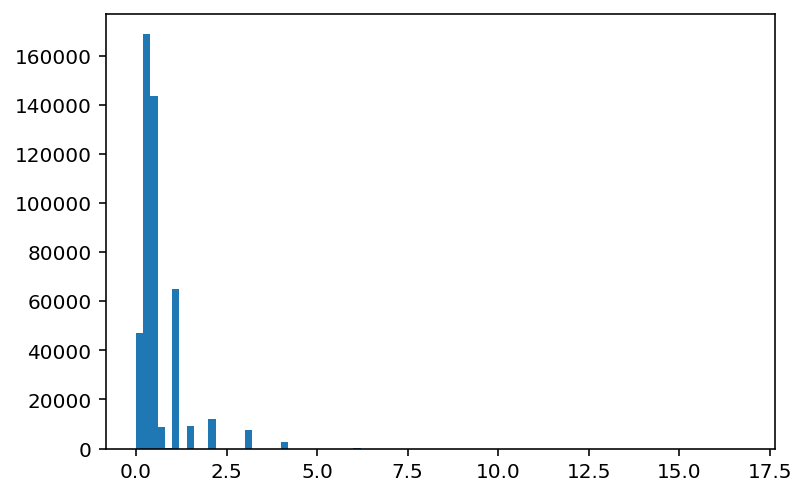

In [22]:
print(max(all_durations), min(all_durations))
plt.hist(all_durations, bins = np.arange(0,17,0.2))

## Produce lisp style (like original mdata) dataset from asap

In [60]:
asap_list_path = Path("./datasets/asap_lisp/")
asap_basepath = Path("../asap-dataset/")

In [61]:
# load the dataset info
df = pd.read_csv(Path(asap_basepath,'metadata.csv'))
df = df.drop_duplicates(subset=["title","composer"])

with open(Path(asap_basepath,'asap_annotations.json')) as json_file:
      json_data = json.load(json_file)

# accidentals_list = [list(json_data[m]["midi_score_key_signatures"].values())[0][1] for m  in df["midi_performance"]]
xml_score_paths = list(df["xml_score"])

print("N of pieces: ", len(xml_score_paths))

N of pieces:  222


In [66]:
for ir,row in df.iterrows():
    path = row["xml_score"]
    title = row['title']
    composer = row['composer']
    print("About to process",path)
    score = m21.converter.parse(Path(asap_basepath,path))
    # onset, pitchname, duration, voice
    onsets = score2onsets(score)
    pitchnames = score2pitches_meredith(score)
    durations = score2durations(score)
    voices = [1 for d in durations] #all same voice
    out="("
    #append all information to the string
    for i,(o,p,d,v) in enumerate(zip(onsets,pitchnames,durations,voices)):
        out += '({} "{}" {} {}) '.format(o,p,d,v)
        if i%3 == 2:
            out += "\n"
    out = out[:-1]+")"
    #save file
    with open(Path(asap_list_path,composer+title+".opnd-m"), "w") as text_file:
        text_file.write(out)

About to process Bach/Fugue/bwv_846/xml_score.musicxml
About to process Bach/Fugue/bwv_848/xml_score.musicxml
About to process Bach/Fugue/bwv_854/xml_score.musicxml
About to process Bach/Fugue/bwv_856/xml_score.musicxml
About to process Bach/Fugue/bwv_857/xml_score.musicxml
About to process Bach/Fugue/bwv_858/xml_score.musicxml
About to process Bach/Fugue/bwv_860/xml_score.musicxml
About to process Bach/Fugue/bwv_862/xml_score.musicxml
About to process Bach/Fugue/bwv_863/xml_score.musicxml
About to process Bach/Fugue/bwv_864/xml_score.musicxml
About to process Bach/Fugue/bwv_865/xml_score.musicxml
About to process Bach/Fugue/bwv_866/xml_score.musicxml
About to process Bach/Fugue/bwv_867/xml_score.musicxml
About to process Bach/Fugue/bwv_868/xml_score.musicxml
About to process Bach/Fugue/bwv_870/xml_score.musicxml
About to process Bach/Fugue/bwv_873/xml_score.musicxml
About to process Bach/Fugue/bwv_874/xml_score.musicxml
About to process Bach/Fugue/bwv_875/xml_score.musicxml
About to p

About to process Chopin/Etudes_op_25/2/xml_score.musicxml
About to process Chopin/Etudes_op_25/4/xml_score.musicxml
About to process Chopin/Etudes_op_25/5/xml_score.musicxml
About to process Chopin/Etudes_op_25/8/xml_score.musicxml
About to process Chopin/Polonaises/53/xml_score.musicxml
About to process Chopin/Scherzos/20/xml_score.musicxml
About to process Chopin/Scherzos/31/xml_score.musicxml
About to process Chopin/Scherzos/39/xml_score.musicxml
About to process Chopin/Sonata_2/1st_no_repeat/xml_score.musicxml
About to process Chopin/Sonata_2/2nd/xml_score.musicxml
About to process Chopin/Sonata_2/3rd/xml_score.musicxml
About to process Chopin/Sonata_2/4th/xml_score.musicxml
About to process Chopin/Sonata_3/2nd/xml_score.musicxml
About to process Chopin/Sonata_3/3rd/xml_score.musicxml
About to process Chopin/Sonata_3/4th/xml_score.musicxml
About to process Debussy/Images_Book_1/1_Reflets_dans_lEau/xml_score.musicxml
About to process Debussy/Pour_le_Piano/1/xml_score.musicxml
About 

# Asap with ks

In [16]:
asap_basepath = Path("../asap-dataset/")

In [17]:
# load the dataset info
df = pd.read_csv(Path(asap_basepath,'metadata.csv'))
df = df.drop_duplicates(subset=["title","composer"])

with open(Path(asap_basepath,'asap_annotations.json')) as json_file:
      json_data = json.load(json_file)

# accidentals_list = [list(json_data[m]["midi_score_key_signatures"].values())[0][1] for m  in df["midi_performance"]]
xml_score_paths = list(df["xml_score"])

print("N of pieces: ", len(xml_score_paths))

N of pieces:  222


In [12]:
asap_dataset_dict = []

for i,path in enumerate(xml_score_paths):
    print("About to process",path)
    score = m21.converter.parse(Path(asap_basepath,path))
    # generate the transpositions for the piece
    all_scores = transp_score(score)
    #delete the pieces with non accepted pitches (e.g. triple sharps)
    intervals= []
    scores = []
    for s,interval in zip(all_scores,accepted_intervals):
        if all(pitch in accepted_pitches for pitch in score2pitches(s)):
            scores.append(s)
            intervals.append(interval)
    #append all information to the dictionary 
    asap_dataset_dict.extend([
        {
            'onset':score2onsets(s),
            'duration' : score2durations(s),
            'pitches': score2pitches(s),
            'transposed_of': interval,
            'midi_number' : score2midi_numbers(s),
            'key_signatures' : s.parts[0].flat.getElementsByClass(m21.key.KeySignature)[0].sharps,
            'original_path' : str(path),
            'composer' : str(path).split("/")[0]
            } 
        for s,interval in zip(scores,intervals)])

About to process Bach/Fugue/bwv_846/xml_score.musicxml
About to process Bach/Fugue/bwv_848/xml_score.musicxml
About to process Bach/Fugue/bwv_854/xml_score.musicxml
About to process Bach/Fugue/bwv_856/xml_score.musicxml
About to process Bach/Fugue/bwv_857/xml_score.musicxml
About to process Bach/Fugue/bwv_858/xml_score.musicxml
About to process Bach/Fugue/bwv_860/xml_score.musicxml
About to process Bach/Fugue/bwv_862/xml_score.musicxml
About to process Bach/Fugue/bwv_863/xml_score.musicxml
About to process Bach/Fugue/bwv_864/xml_score.musicxml
About to process Bach/Fugue/bwv_865/xml_score.musicxml
About to process Bach/Fugue/bwv_866/xml_score.musicxml
About to process Bach/Fugue/bwv_867/xml_score.musicxml
About to process Bach/Fugue/bwv_868/xml_score.musicxml
About to process Bach/Fugue/bwv_870/xml_score.musicxml
About to process Bach/Fugue/bwv_873/xml_score.musicxml
About to process Bach/Fugue/bwv_874/xml_score.musicxml
About to process Bach/Fugue/bwv_875/xml_score.musicxml
About to p

About to process Chopin/Etudes_op_25/2/xml_score.musicxml
About to process Chopin/Etudes_op_25/4/xml_score.musicxml
About to process Chopin/Etudes_op_25/5/xml_score.musicxml
About to process Chopin/Etudes_op_25/8/xml_score.musicxml
About to process Chopin/Polonaises/53/xml_score.musicxml
About to process Chopin/Scherzos/20/xml_score.musicxml
About to process Chopin/Scherzos/31/xml_score.musicxml
About to process Chopin/Scherzos/39/xml_score.musicxml
About to process Chopin/Sonata_2/1st_no_repeat/xml_score.musicxml
About to process Chopin/Sonata_2/2nd/xml_score.musicxml
About to process Chopin/Sonata_2/3rd/xml_score.musicxml
About to process Chopin/Sonata_2/4th/xml_score.musicxml
About to process Chopin/Sonata_3/2nd/xml_score.musicxml
About to process Chopin/Sonata_3/3rd/xml_score.musicxml
About to process Chopin/Sonata_3/4th/xml_score.musicxml
About to process Debussy/Images_Book_1/1_Reflets_dans_lEau/xml_score.musicxml
About to process Debussy/Pour_le_Piano/1/xml_score.musicxml
About 

In [13]:
# save dataset
with open('asap.pkl', 'wb') as fid:
     pickle.dump(asap_dataset_dict, fid)

# Albrecht

In [4]:
albrecht_basepath = Path("../albrecht_symbolic/features/")
albrecht_key_path = Path("../albrecht_symbolic/annotations/")

midi_paths = [p for p in albrecht_basepath.iterdir()]

print("N of pieces: ", len(midi_paths))

N of pieces:  981


In [5]:
for m in midi_paths:
    with open(Path(albrecht_key_path,m.stem +".key")) as f:
        key = f.read()
    print (m)
    print(m21.key.Key(key))
    

..\albrecht_symbolic\features\barber01.mid
C major
..\albrecht_symbolic\features\barber02.mid
E- major
..\albrecht_symbolic\features\barber03.mid
E- major
..\albrecht_symbolic\features\barber04.mid
E- major
..\albrecht_symbolic\features\barber05.mid
B- major
..\albrecht_symbolic\features\barber06.mid
C major
..\albrecht_symbolic\features\barber07.mid
A- major
..\albrecht_symbolic\features\barber08.mid
C major
..\albrecht_symbolic\features\barber09.mid
C major
..\albrecht_symbolic\features\barber10.mid
G major
..\albrecht_symbolic\features\barber11.mid
F major
..\albrecht_symbolic\features\barber12.mid
E- major
..\albrecht_symbolic\features\barber13.mid
E- major
..\albrecht_symbolic\features\barber14.mid
F major
..\albrecht_symbolic\features\barber15.mid
A major
..\albrecht_symbolic\features\barber16.mid
F major
..\albrecht_symbolic\features\barber17.mid
F major
..\albrecht_symbolic\features\barber18.mid
G major
..\albrecht_symbolic\features\barber19.mid
F major
..\albrecht_symbolic\fea

g minor
..\albrecht_symbolic\features\chor282.mid
C major
..\albrecht_symbolic\features\chor283.mid
e minor
..\albrecht_symbolic\features\chor285.mid
a minor
..\albrecht_symbolic\features\chor286.mid
b minor
..\albrecht_symbolic\features\chor287.mid
a minor
..\albrecht_symbolic\features\chor289.mid
B- major
..\albrecht_symbolic\features\chor290.mid
E major
..\albrecht_symbolic\features\chor291.mid
D major
..\albrecht_symbolic\features\chor292.mid
d minor
..\albrecht_symbolic\features\chor293.mid
G major
..\albrecht_symbolic\features\chor294.mid
b minor
..\albrecht_symbolic\features\chor295.mid
e minor
..\albrecht_symbolic\features\chor296.mid
C major
..\albrecht_symbolic\features\chor297.mid
g minor
..\albrecht_symbolic\features\chor298.mid
C major
..\albrecht_symbolic\features\chor299.mid
E- major
..\albrecht_symbolic\features\chor300.mid
a minor
..\albrecht_symbolic\features\chor301.mid
g minor
..\albrecht_symbolic\features\chor303.mid
F major
..\albrecht_symbolic\features\chor304.mi

c minor
..\albrecht_symbolic\features\op01n08d.mid
c minor
..\albrecht_symbolic\features\op01n09a.mid
G major
..\albrecht_symbolic\features\op01n09b.mid
G major
..\albrecht_symbolic\features\op01n09d.mid
G major
..\albrecht_symbolic\features\op01n1-01.mid
B- major
..\albrecht_symbolic\features\op01n1-02.mid
B- major
..\albrecht_symbolic\features\op01n1-03.mid
E- major
..\albrecht_symbolic\features\op01n1-04.mid
B- major
..\albrecht_symbolic\features\op01n1-05.mid
B- major
..\albrecht_symbolic\features\op01n10a.mid
g minor
..\albrecht_symbolic\features\op01n10b.mid
g minor
..\albrecht_symbolic\features\op01n10c.mid
g minor
..\albrecht_symbolic\features\op01n10d.mid
g minor
..\albrecht_symbolic\features\op01n11a.mid
d minor
..\albrecht_symbolic\features\op01n11b.mid
d minor
..\albrecht_symbolic\features\op01n11c.mid
d minor
..\albrecht_symbolic\features\op01n11d.mid
d minor
..\albrecht_symbolic\features\op01n12a.mid
D major
..\albrecht_symbolic\features\op01n12b.mid
D major
..\albrecht_s

B- major
..\albrecht_symbolic\features\quartet13-6.mid
B- major
..\albrecht_symbolic\features\quartet14-1.mid
c# minor
..\albrecht_symbolic\features\quartet14-7.mid
c# minor
..\albrecht_symbolic\features\quartet15-1.mid
a minor
..\albrecht_symbolic\features\quartet15-5.mid
a minor
..\albrecht_symbolic\features\quartet16-1.mid
F major
..\albrecht_symbolic\features\sinfo01.mid
C major
..\albrecht_symbolic\features\sinfo02.mid
c minor
..\albrecht_symbolic\features\sinfo03.mid
D major
..\albrecht_symbolic\features\sinfo04.mid
d minor
..\albrecht_symbolic\features\sinfo05.mid
E- major
..\albrecht_symbolic\features\sinfo06.mid
E major
..\albrecht_symbolic\features\sinfo07.mid
e minor
..\albrecht_symbolic\features\sinfo08.mid
F major
..\albrecht_symbolic\features\sinfo09.mid
f minor
..\albrecht_symbolic\features\sinfo10.mid
G major
..\albrecht_symbolic\features\sinfo11.mid
g minor
..\albrecht_symbolic\features\sinfo12.mid
A major
..\albrecht_symbolic\features\sinfo13.mid
a minor
..\albrecht_s

In [9]:
albrecht_dataset_dict = []

for ifile,file in enumerate(albrecht_basepath.iterdir()):
    print("Processing file", ifile, str(file))
    # read key annotation
    with open(Path(albrecht_key_path,file.stem +".key")) as f:
        key = f.read()
    print(file,key)
    ks = m21.key.Key(key).sharps
    # get all notes from midi file
    midi = pm.PrettyMIDI(str(file))
    notes = [n for inst in midi.instruments for n in inst.notes] 
    # sort according to start time and pitch
    notes = sorted(notes, key=lambda x: (x.start, x.pitch)) 
    # build the list of dicts
    albrecht_dataset_dict.append({
        'duration' : [n.end-n.start for n in notes],
        'pitches': None,
        'midi_number' : [n.pitch%12 for n in notes],
        'transposed_of' : "P1", #not interested in data augmentation, just take the original piece
        'key_signature' : [ks],
        'original_path' : str(file)
    })

Processing file 0 ..\albrecht_symbolic\features\barber01.mid
..\albrecht_symbolic\features\barber01.mid C
Processing file 1 ..\albrecht_symbolic\features\barber02.mid
..\albrecht_symbolic\features\barber02.mid Eb
Processing file 2 ..\albrecht_symbolic\features\barber03.mid
..\albrecht_symbolic\features\barber03.mid Eb
Processing file 3 ..\albrecht_symbolic\features\barber04.mid
..\albrecht_symbolic\features\barber04.mid Eb
Processing file 4 ..\albrecht_symbolic\features\barber05.mid
..\albrecht_symbolic\features\barber05.mid Bb
Processing file 5 ..\albrecht_symbolic\features\barber06.mid
..\albrecht_symbolic\features\barber06.mid C
Processing file 6 ..\albrecht_symbolic\features\barber07.mid
..\albrecht_symbolic\features\barber07.mid Ab
Processing file 7 ..\albrecht_symbolic\features\barber08.mid
..\albrecht_symbolic\features\barber08.mid C
Processing file 8 ..\albrecht_symbolic\features\barber09.mid
..\albrecht_symbolic\features\barber09.mid C
Processing file 9 ..\albrecht_symbolic\fe

..\albrecht_symbolic\features\chor043.mid E
Processing file 98 ..\albrecht_symbolic\features\chor044.mid
..\albrecht_symbolic\features\chor044.mid D
Processing file 99 ..\albrecht_symbolic\features\chor045.mid
..\albrecht_symbolic\features\chor045.mid b
Processing file 100 ..\albrecht_symbolic\features\chor046.mid
..\albrecht_symbolic\features\chor046.mid D
Processing file 101 ..\albrecht_symbolic\features\chor047.mid
..\albrecht_symbolic\features\chor047.mid d
Processing file 102 ..\albrecht_symbolic\features\chor048.mid
..\albrecht_symbolic\features\chor048.mid a
Processing file 103 ..\albrecht_symbolic\features\chor050.mid
..\albrecht_symbolic\features\chor050.mid F
Processing file 104 ..\albrecht_symbolic\features\chor051.mid
..\albrecht_symbolic\features\chor051.mid G
Processing file 105 ..\albrecht_symbolic\features\chor052.mid
..\albrecht_symbolic\features\chor052.mid A
Processing file 106 ..\albrecht_symbolic\features\chor053.mid
..\albrecht_symbolic\features\chor053.mid g
Proc

Processing file 181 ..\albrecht_symbolic\features\chor137.mid
..\albrecht_symbolic\features\chor137.mid G
Processing file 182 ..\albrecht_symbolic\features\chor138.mid
..\albrecht_symbolic\features\chor138.mid e
Processing file 183 ..\albrecht_symbolic\features\chor139.mid
..\albrecht_symbolic\features\chor139.mid G
Processing file 184 ..\albrecht_symbolic\features\chor140.mid
..\albrecht_symbolic\features\chor140.mid C
Processing file 185 ..\albrecht_symbolic\features\chor141.mid
..\albrecht_symbolic\features\chor141.mid A
Processing file 186 ..\albrecht_symbolic\features\chor142.mid
..\albrecht_symbolic\features\chor142.mid d
Processing file 187 ..\albrecht_symbolic\features\chor143.mid
..\albrecht_symbolic\features\chor143.mid F
Processing file 188 ..\albrecht_symbolic\features\chor144.mid
..\albrecht_symbolic\features\chor144.mid A
Processing file 189 ..\albrecht_symbolic\features\chor145.mid
..\albrecht_symbolic\features\chor145.mid a
Processing file 190 ..\albrecht_symbolic\featu

Processing file 264 ..\albrecht_symbolic\features\chor245.mid
..\albrecht_symbolic\features\chor245.mid g
Processing file 265 ..\albrecht_symbolic\features\chor246.mid
..\albrecht_symbolic\features\chor246.mid G
Processing file 266 ..\albrecht_symbolic\features\chor247.mid
..\albrecht_symbolic\features\chor247.mid G
Processing file 267 ..\albrecht_symbolic\features\chor248.mid
..\albrecht_symbolic\features\chor248.mid G
Processing file 268 ..\albrecht_symbolic\features\chor249.mid
..\albrecht_symbolic\features\chor249.mid G
Processing file 269 ..\albrecht_symbolic\features\chor250.mid
..\albrecht_symbolic\features\chor250.mid D
Processing file 270 ..\albrecht_symbolic\features\chor251.mid
..\albrecht_symbolic\features\chor251.mid g
Processing file 271 ..\albrecht_symbolic\features\chor252.mid
..\albrecht_symbolic\features\chor252.mid Bb
Processing file 272 ..\albrecht_symbolic\features\chor253.mid
..\albrecht_symbolic\features\chor253.mid g
Processing file 273 ..\albrecht_symbolic\feat

Processing file 346 ..\albrecht_symbolic\features\chor332.mid
..\albrecht_symbolic\features\chor332.mid a
Processing file 347 ..\albrecht_symbolic\features\chor333.mid
..\albrecht_symbolic\features\chor333.mid D
Processing file 348 ..\albrecht_symbolic\features\chor334.mid
..\albrecht_symbolic\features\chor334.mid D
Processing file 349 ..\albrecht_symbolic\features\chor335.mid
..\albrecht_symbolic\features\chor335.mid F
Processing file 350 ..\albrecht_symbolic\features\chor336.mid
..\albrecht_symbolic\features\chor336.mid b
Processing file 351 ..\albrecht_symbolic\features\chor337.mid
..\albrecht_symbolic\features\chor337.mid F
Processing file 352 ..\albrecht_symbolic\features\chor338.mid
..\albrecht_symbolic\features\chor338.mid D
Processing file 353 ..\albrecht_symbolic\features\chor339.mid
..\albrecht_symbolic\features\chor339.mid a
Processing file 354 ..\albrecht_symbolic\features\chor340.mid
..\albrecht_symbolic\features\chor340.mid d
Processing file 355 ..\albrecht_symbolic\featu

..\albrecht_symbolic\features\k159-01.mid Bb
Processing file 426 ..\albrecht_symbolic\features\k160-03.mid
..\albrecht_symbolic\features\k160-03.mid Eb
Processing file 427 ..\albrecht_symbolic\features\k160D.mid
..\albrecht_symbolic\features\k160D.mid D
Processing file 428 ..\albrecht_symbolic\features\k165C.mid
..\albrecht_symbolic\features\k165C.mid C
Processing file 429 ..\albrecht_symbolic\features\k166C.mid
..\albrecht_symbolic\features\k166C.mid C
Processing file 430 ..\albrecht_symbolic\features\k168-01.mid
..\albrecht_symbolic\features\k168-01.mid F
Processing file 431 ..\albrecht_symbolic\features\k168-04.mid
..\albrecht_symbolic\features\k168-04.mid F
Processing file 432 ..\albrecht_symbolic\features\k169-01.mid
..\albrecht_symbolic\features\k169-01.mid A
Processing file 433 ..\albrecht_symbolic\features\k169-04.mid
..\albrecht_symbolic\features\k169-04.mid A
Processing file 434 ..\albrecht_symbolic\features\k170-04.mid
..\albrecht_symbolic\features\k170-04.mid C
Processing f

Processing file 507 ..\albrecht_symbolic\features\k589-03.mid
..\albrecht_symbolic\features\k589-03.mid Bb
Processing file 508 ..\albrecht_symbolic\features\k589-04.mid
..\albrecht_symbolic\features\k589-04.mid Bb
Processing file 509 ..\albrecht_symbolic\features\k590-01.mid
..\albrecht_symbolic\features\k590-01.mid F
Processing file 510 ..\albrecht_symbolic\features\k590-04.mid
..\albrecht_symbolic\features\k590-04.mid F
Processing file 511 ..\albrecht_symbolic\features\k60g.mid
..\albrecht_symbolic\features\k60g.mid g
Processing file 512 ..\albrecht_symbolic\features\k75G.mid
..\albrecht_symbolic\features\k75G.mid G
Processing file 513 ..\albrecht_symbolic\features\k84c.mid
..\albrecht_symbolic\features\k84c.mid c
Processing file 514 ..\albrecht_symbolic\features\k85F.mid
..\albrecht_symbolic\features\k85F.mid F
Processing file 515 ..\albrecht_symbolic\features\k93g.mid
..\albrecht_symbolic\features\k93g.mid g
Processing file 516 ..\albrecht_symbolic\features\kabalev1.mid
..\albrecht

..\albrecht_symbolic\features\op01n06b.mid b
Processing file 593 ..\albrecht_symbolic\features\op01n06c.mid
..\albrecht_symbolic\features\op01n06c.mid b
Processing file 594 ..\albrecht_symbolic\features\op01n06d.mid
..\albrecht_symbolic\features\op01n06d.mid b
Processing file 595 ..\albrecht_symbolic\features\op01n07a.mid
..\albrecht_symbolic\features\op01n07a.mid C
Processing file 596 ..\albrecht_symbolic\features\op01n08a.mid
..\albrecht_symbolic\features\op01n08a.mid c
Processing file 597 ..\albrecht_symbolic\features\op01n08b.mid
..\albrecht_symbolic\features\op01n08b.mid c
Processing file 598 ..\albrecht_symbolic\features\op01n08c.mid
..\albrecht_symbolic\features\op01n08c.mid c
Processing file 599 ..\albrecht_symbolic\features\op01n08d.mid
..\albrecht_symbolic\features\op01n08d.mid c
Processing file 600 ..\albrecht_symbolic\features\op01n09a.mid
..\albrecht_symbolic\features\op01n09a.mid G
Processing file 601 ..\albrecht_symbolic\features\op01n09b.mid
..\albrecht_symbolic\feature

Processing file 671 ..\albrecht_symbolic\features\op20n3-04.mid
..\albrecht_symbolic\features\op20n3-04.mid g
Processing file 672 ..\albrecht_symbolic\features\op20n4-04.mid
..\albrecht_symbolic\features\op20n4-04.mid D
Processing file 673 ..\albrecht_symbolic\features\op20n5-01.mid
..\albrecht_symbolic\features\op20n5-01.mid f
Processing file 674 ..\albrecht_symbolic\features\op20n5-04.mid
..\albrecht_symbolic\features\op20n5-04.mid f
Processing file 675 ..\albrecht_symbolic\features\op20n6-01.mid
..\albrecht_symbolic\features\op20n6-01.mid A
Processing file 676 ..\albrecht_symbolic\features\op20n6-04.mid
..\albrecht_symbolic\features\op20n6-04.mid A
Processing file 677 ..\albrecht_symbolic\features\op22-01.mid
..\albrecht_symbolic\features\op22-01.mid Bb
Processing file 678 ..\albrecht_symbolic\features\op22-04.mid
..\albrecht_symbolic\features\op22-04.mid Bb
Processing file 679 ..\albrecht_symbolic\features\op26-01.mid
..\albrecht_symbolic\features\op26-01.mid Ab
Processing file 680

Processing file 747 ..\albrecht_symbolic\features\op64n4-04.mid
..\albrecht_symbolic\features\op64n4-04.mid G
Processing file 748 ..\albrecht_symbolic\features\op64n5-04.mid
..\albrecht_symbolic\features\op64n5-04.mid D
Processing file 749 ..\albrecht_symbolic\features\op64n6-01.mid
..\albrecht_symbolic\features\op64n6-01.mid Eb
Processing file 750 ..\albrecht_symbolic\features\op64n6-04.mid
..\albrecht_symbolic\features\op64n6-04.mid Eb
Processing file 751 ..\albrecht_symbolic\features\op7-01.mid
..\albrecht_symbolic\features\op7-01.mid Eb
Processing file 752 ..\albrecht_symbolic\features\op7-04.mid
..\albrecht_symbolic\features\op7-04.mid Eb
Processing file 753 ..\albrecht_symbolic\features\op71n1-01.mid
..\albrecht_symbolic\features\op71n1-01.mid Bb
Processing file 754 ..\albrecht_symbolic\features\op71n1-04.mid
..\albrecht_symbolic\features\op71n1-04.mid Bb
Processing file 755 ..\albrecht_symbolic\features\op71n2-01.mid
..\albrecht_symbolic\features\op71n2-01.mid D
Processing file 

Processing file 833 ..\albrecht_symbolic\features\prelud67-20.mid
..\albrecht_symbolic\features\prelud67-20.mid c
Processing file 834 ..\albrecht_symbolic\features\prelud67-21.mid
..\albrecht_symbolic\features\prelud67-21.mid Bb
Processing file 835 ..\albrecht_symbolic\features\prelud67-22.mid
..\albrecht_symbolic\features\prelud67-22.mid g
Processing file 836 ..\albrecht_symbolic\features\prelud67-23.mid
..\albrecht_symbolic\features\prelud67-23.mid F
Processing file 837 ..\albrecht_symbolic\features\prelud67-24.mid
..\albrecht_symbolic\features\prelud67-24.mid d
Processing file 838 ..\albrecht_symbolic\features\prelude28-01.mid
..\albrecht_symbolic\features\prelude28-01.mid C
Processing file 839 ..\albrecht_symbolic\features\prelude28-02.mid
..\albrecht_symbolic\features\prelude28-02.mid a
Processing file 840 ..\albrecht_symbolic\features\prelude28-03.mid
..\albrecht_symbolic\features\prelude28-03.mid G
Processing file 841 ..\albrecht_symbolic\features\prelude28-04.mid
..\albrecht_sy

Processing file 911 ..\albrecht_symbolic\features\teleman7.mid
..\albrecht_symbolic\features\teleman7.mid A
Processing file 912 ..\albrecht_symbolic\features\wtc1f01.mid
..\albrecht_symbolic\features\wtc1f01.mid C
Processing file 913 ..\albrecht_symbolic\features\wtc1f02.mid
..\albrecht_symbolic\features\wtc1f02.mid c
Processing file 914 ..\albrecht_symbolic\features\wtc1f03.mid
..\albrecht_symbolic\features\wtc1f03.mid C#
Processing file 915 ..\albrecht_symbolic\features\wtc1f04.mid
..\albrecht_symbolic\features\wtc1f04.mid c#
Processing file 916 ..\albrecht_symbolic\features\wtc1f05.mid
..\albrecht_symbolic\features\wtc1f05.mid D
Processing file 917 ..\albrecht_symbolic\features\wtc1f06.mid
..\albrecht_symbolic\features\wtc1f06.mid d
Processing file 918 ..\albrecht_symbolic\features\wtc1f07.mid
..\albrecht_symbolic\features\wtc1f07.mid Eb
Processing file 919 ..\albrecht_symbolic\features\wtc1f08.mid
..\albrecht_symbolic\features\wtc1f08.mid d#
Processing file 920 ..\albrecht_symbolic

In [8]:
# save dataset
with open(Path('./datasets/albrecht.pkl'), 'wb') as fid:
     pickle.dump(albrecht_dataset_dict, fid)

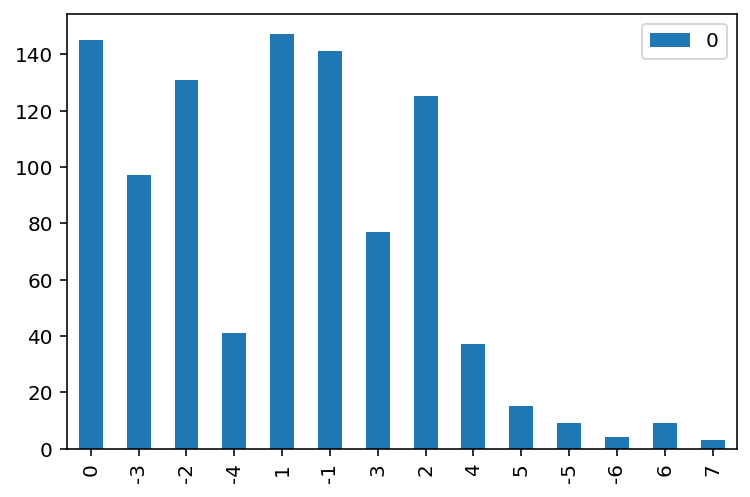

In [68]:
import pandas
from collections import Counter
ks = [e["key_signature"][0] for e in albrecht_dataset_dict]
ks_counts = Counter(ks)
df = pandas.DataFrame.from_dict(ks_counts, orient='index')
df.plot(kind='bar')

# Cluster durations

With jensks

In [7]:
import jenkspy

bach1_dur=np.array(full_dict_dataset[356]["duration"])
bach1_dur.shape
breaks = jenkspy.jenks_breaks(bach1_dur, nb_class=4)
print(breaks)
quantized_durations = np.digitize(bach1_dur,breaks)
print(Counter(quantized_durations))

NameError: name 'full_dict_dataset' is not defined

With min in Kernel density estimation

[ -7.39414529  -6.18446577  -6.28938514  -7.32994204  -8.15512303
  -8.87092851  -9.79566138  -9.48658201  -9.77270215  -9.84566173
 -10.56457362 -10.27221509 -10.33934578 -10.40660388 -10.25725337
 -11.73561594 -11.91448952 -11.8291786  -13.09026381 -16.63505016
 -14.42240169 -11.88977683 -11.84024384 -14.19890704 -18.96788508
 -16.61970284 -13.08681846 -11.50384459 -11.68468584 -12.44023605
 -12.67778796 -12.83896431 -15.29342712 -20.40470996 -19.75739506
 -14.91929678 -12.74653543 -13.2393301  -16.39768079 -22.22158747
 -28.78124225 -20.74618198 -15.21981797 -12.35900997 -12.16375799
 -14.63406203 -19.76992209 -27.57133817 -38.03831026 -51.17083837]
Minima: [ 979.59183673 1632.65306122 2122.44897959 2612.24489796 3102.04081633
 3918.36734694 5387.75510204 6530.6122449 ]


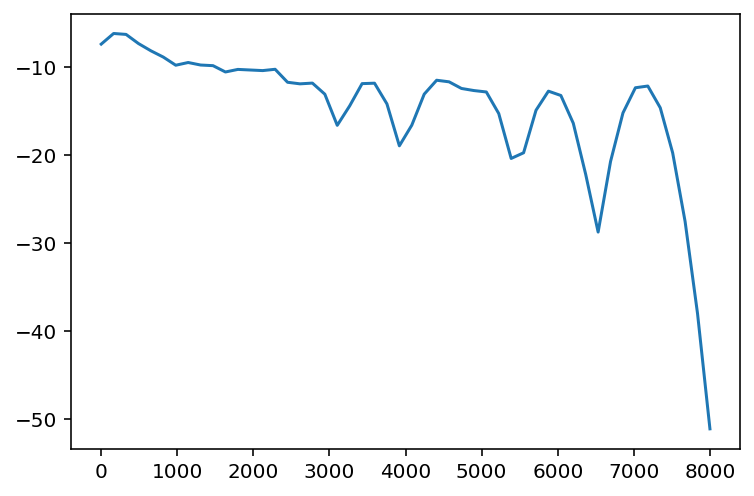

In [105]:
from sklearn.neighbors.kde import KernelDensity
from scipy.stats import gaussian_kde
from matplotlib.pyplot import plot, hist
from scipy.signal import argrelmin


with open('./datasets/musedata_noisy.pkl', 'rb') as fid:
     dataset_dict = pickle.load( fid)
# with open('./datasets/baroque_aug_asap.pkl', 'rb') as fid:
#      dataset_dict = pickle.load( fid)
        
a = np.array(dataset_dict[1]["duration"])
kde1 = KernelDensity(kernel='gaussian', bandwidth=100).fit(a.reshape(-1, 1))
kde2 = gaussian_kde(a,bw_method=0.1 )
s = np.linspace(0,8000)
e1 = kde1.score_samples(s.reshape(-1,1))
e2 = kde2.evaluate(s)

print(e1)
plot(s, e1)
# plot(s,e2)

min_indices = argrelmin(e1)
min_values = a[min_indices]
print("Minima:", s[min_indices])


With 1d kmeans

In [52]:
from sklearn.neighbors import KernelDensity
import pandas as pd

def plot_duration_clusters(data,clusters, centroids):
    # create a pandas dataframe
    temp_dict = {"duration":data, "cluster":clusters}
    temp_df = pd.DataFrame(temp_dict)
    #plot seaborn
    palette = sns.color_palette(palette="tab10",as_cmap=True)
    sns.kdeplot(data=temp_df, x="duration")
    sns.rugplot(data=temp_df, x="duration",hue ="cluster",height=.1, palette = "tab10" )
    #plot centroids
    for ic,cen in enumerate(centroids):
        plt.plot(cen,0,'ro') 

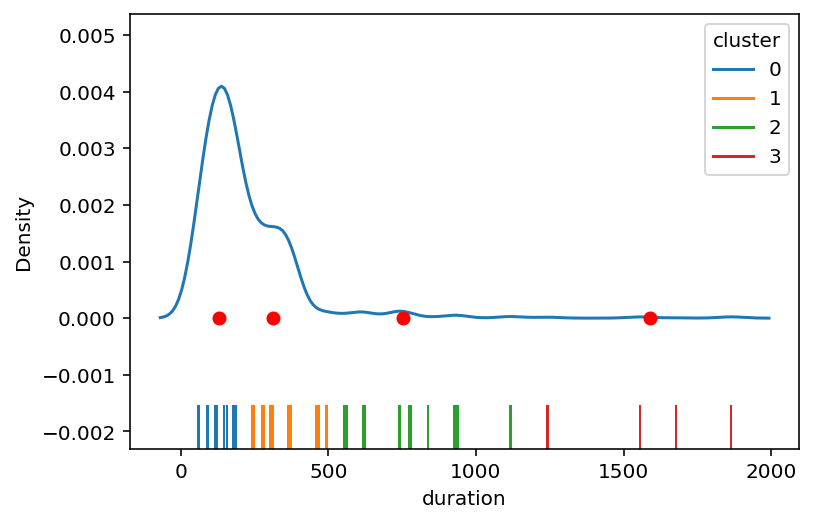

In [53]:
import kmeans1d
# with open('./datasets/aug_musedata.pkl', 'rb') as fid:
#      dataset_dict = pickle.load( fid)
with open('./datasets/musedata_noisy.pkl', 'rb') as fid:
     dataset_dict = pickle.load( fid)
# with open('./datasets/baroque_aug_asap.pkl', 'rb') as fid:
#      dataset_dict = pickle.load( fid)
        

a = np.array(dataset_dict[0]["duration"])
clusters, centroids = kmeans1d.cluster(a, 4)

plot_duration_clusters(a,clusters, centroids)

In [69]:
pitch30 = ['G', 'G', 'B', 'D', 'G', 'G', 'D', 'B', 'D', 'B', 'G', 'B', 'G', 'G', 'D', 'E', 'G', 'G', 'C', 'E', 'G', 'C', 'G', 'C', 'G', 'E', 'G', 'G', 'E', 'C']
[e["original_path"] for e in full_dict_dataset if e["pitches"][:30]==pitch30]

['Bach/Prelude/bwv_860/xml_score.musicxml']

In [72]:
len([e for e in dataset_dict if e["original_path"]== 'Bach/Prelude/bwv_860/xml_score.musicxml'
    and e["transposed_of"] == "P1"])

1